# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models
from torchvision.transforms import ToTensor

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

! pip install -q kaggle

# Fetch data

First, upload your kaggle.json file:


In [ ]:
# NOTE: having files downloaded here instead of fetching from Drive is much faster to read
from google.colab import files 
files.upload()

! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


We now download the dataset:

In [ ]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 604M/612M [00:04<00:00, 142MB/s]
100% 612M/612M [00:04<00:00, 159MB/s]


In [ ]:
!unzip gtsrb-german-traffic-sign -d data

data_path = "./data"

Streaming output truncated to the last 5000 lines.
  inflating: data/train/5/00005_00053_00010.png  
  inflating: data/train/5/00005_00053_00011.png  
  inflating: data/train/5/00005_00053_00012.png  
  inflating: data/train/5/00005_00053_00013.png  
  inflating: data/train/5/00005_00053_00014.png  
  inflating: data/train/5/00005_00053_00015.png  
  inflating: data/train/5/00005_00053_00016.png  
  inflating: data/train/5/00005_00053_00017.png  
  inflating: data/train/5/00005_00053_00018.png  
  inflating: data/train/5/00005_00053_00019.png  
  inflating: data/train/5/00005_00053_00020.png  
  inflating: data/train/5/00005_00053_00021.png  
  inflating: data/train/5/00005_00053_00022.png  
  inflating: data/train/5/00005_00053_00023.png  
  inflating: data/train/5/00005_00053_00024.png  
  inflating: data/train/5/00005_00053_00025.png  
  inflating: data/train/5/00005_00053_00026.png  
  inflating: data/train/5/00005_00053_00027.png  
  inflating: data/train/5/00005_00053_00028.png  

# GTSRBDataset

Our GTSRB dataset is a bit different from the GTSRB dataset available from PyTorch: the number of images each one has is different.

To make working with the data easier, we will wrap it in a GTSRBDataset class:

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class GTSRBDataset(Dataset):
  def __init__(self, root, train, transform=None, target_transform=None):
    img_path = "Train" if train else "Test"
    labels_path = "Train.csv" if train else "Test.csv"

    img_dir_path = os.path.join(root, img_path)
    img_labels_path = os.path.join(root, labels_path)

    self.root = root

    self.img_labels = pd.read_csv(img_labels_path)
    self.img_dir = img_dir_path

    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = self.img_labels.iloc[idx, 7]
    img_path = os.path.join(self.root, img_path)

    image = read_image(img_path)

    label = self.img_labels.iloc[idx, 6]

    if self.transform is not None:
      image = self.transform(image)
    if self.target_transform is not None:
      label = self.target_transform(label)

    return image, label

# Training, Validation, and Testing datasets, and Transforms

Let's first define the Transforms for our data. 

In [ ]:
data_mean = np.array([0.3337, 0.3064, 0.3171])
data_std = np.array([0.2672, 0.2564, 0.2629])

# Resize all images to 32 * 32 and normalize them
data_transforms = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize([32, 32]),
  transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
  ToTensor(),
  transforms.Normalize(data_mean, data_std)
])

data_transforms_rpt = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize([224, 224]),
  transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
  ToTensor(),
  transforms.Normalize(data_mean, data_std)
])

data_transforms_inc = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize([299, 299]),
  transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
  ToTensor(),
  transforms.Normalize(data_mean, data_std)
])


Now, let's create our training and test set. Then, we split the training set up into training and validation sets with 80% of the data being randomly assigned to the training set and the rest being assigned to the validation set.

In [ ]:
trainset = GTSRBDataset(
    root=data_path,
    train=True,
    transform=data_transforms,
)
testset = GTSRBDataset(
    root=data_path,
    train=False,
    transform=data_transforms,
)

trainset_rpt = GTSRBDataset(
    root=data_path,
    train=True,
    transform=data_transforms_rpt,
)
testset_rpt = GTSRBDataset(
    root=data_path,
    train=False,
    transform=data_transforms_rpt,
)

trainset_inc = GTSRBDataset(
    root=data_path,
    train=True,
    transform=data_transforms_inc,
)
testset_inc = GTSRBDataset(
    root=data_path,
    train=False,
    transform=data_transforms_inc,
)

In [ ]:
train_size = len(trainset)
print(f"Size of training set before split: {train_size}\n")

split_ratio = 0.8
new_train_size = int(train_size * split_ratio)
print(f"Size of training set after split: {new_train_size}\n")

val_size = train_size - new_train_size
print(f"Size of validation set: {val_size}\n")

test_size = len(testset)
print(f"Size of testing set: {test_size}")

Size of training set before split: 39209

Size of training set after split: 31367

Size of validation set: 7842

Size of testing set: 12630


In [ ]:
trainset, valset = torch.utils.data.random_split(trainset, [new_train_size, val_size])
trainset_rpt, valset_rpt = torch.utils.data.random_split(trainset_rpt, [new_train_size, val_size])
trainset_inc, valset_inc = torch.utils.data.random_split(trainset_inc, [new_train_size, val_size])

# Visualizing the data

The possible labels/classes of our data are the following:

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing vehicles > 3.5 tons' }

Let's see the first eight images (before transformation) in the testing set and their corresponding labels:

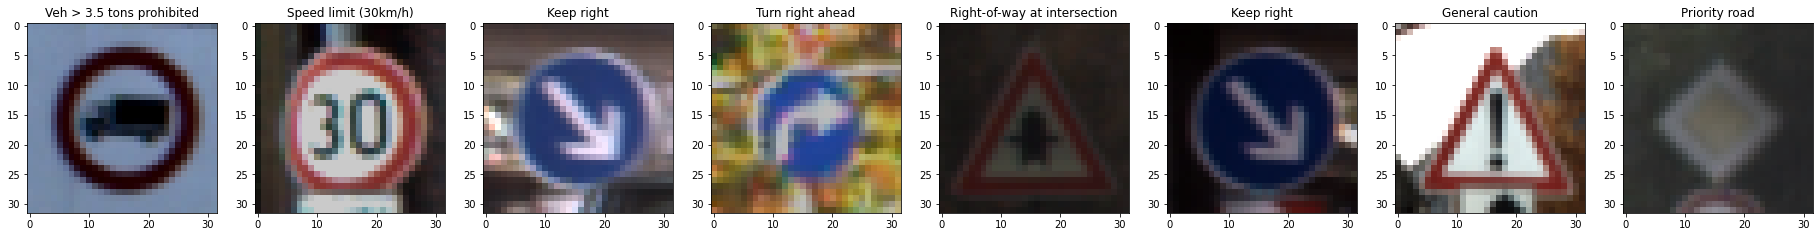

In [ ]:
fig = plt.figure(figsize=(32, 32))

for i in range(8):
  fig.add_subplot(1, 8, i+1)

  label = testset[i][1]
  label = classes[label]
  plt.title(label)

  img = testset[i][0].numpy()
  img = np.transpose(img, (1, 2, 0))
  img = img * data_std + data_mean

  plt.imshow(img)

plt.show()

Although the images are pixelated, they are easily distinguishable from each other.

And now let's visualize the distribution of the Training and Validation data among the labels:
classes are zero-indexed, so for the graph we shifted it over by 1.

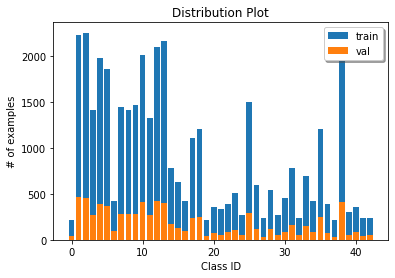

In [ ]:
train_plot = [0]*len(classes)
val_plot = [0]*len(classes)
combine_plot = [0]*len(classes)

for (_, label) in trainset:
  train_plot[label] += 1

for (_, label) in valset:
  val_plot[label] += 1

for i in range(43):
  combine_plot[i] = train_plot[i]+val_plot[i]

plt.bar(range(len(classes)), combine_plot, label="train")
plt.bar(range(len(classes)), val_plot, label="val")

legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.show()

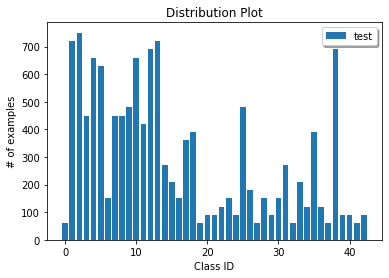

In [ ]:
test_plot = [0]*len(classes)

for (_, label) in testset:
  test_plot[label] += 1

plt.bar(range(len(classes)), test_plot, label="test")

legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.show()

We note that the distribution of the training plus validation set is similar to the distribution of the testing set. The training and validation sets are also similar distributed.

However, we note that some classes are over-represented. For example, class 2('Speed limit (50km/h)', which is class 2 on the `classes` variable but class `3` in the graph since it is shifted by one) has more than 800 testing samples and more 2000 training samples; while the last class has less than 100 testing samples and around 200 training samples).

We can then expected that the classes with few training samples may overfit compared to the better represented labels.

# ResNet

ResNets, or residual networks, are a class of convolutional neural networks that utilize skip connections to alleviate the degradation problem. The degradation problem is the (non) intuitive observation that, when the network gets deeper, the training error is actually larger than a shallower network. Consequently, the model ends up performing worse on the testing set too. An important observation is that, since this happens on the training set, the degradation problem is not caused by overfitting. 

We implemented our own custom 18-layer ResNet: the first layer, 16 "residual layers", and the last layer. Note that each "residual layer" is a residual block. A residual block is, in turn, composed of lots of individual things (explained below).

In this specific implementation, the ResNet consists of a first step with a convolutional operation, followed by a batch normalization operation and a max pooling operation. After that, the network consists of several residual blocks. A residual block is a type of building block that is commonly used in ResNets. It consists of two convolutional layers with batch normalization and ReLU activation, followed by a skip connection that allows the input to bypass the convolutional layers and be added directly to the output of the block.

To test the effectiveness of these residual blocks, we separately implemented a model with the same architecture without residual blocks.

The variables above do the following:
- `middle_layers`: defines the number of residual blocks that have 64, 128, 256, and 512 channels, respectively.
- `middle_layers_channel`: number of channels for each layer
- `middle_layers_prev_channels`: the number of channels of the layer right before the current one

Note that the first layer, which has 64 channels, is special: there are no residual layers before it.

In [ ]:
middle_layers = [2, 2, 2, 2]
middle_layers_channel = [64, 128, 256, 512]
middle_layers_prev_channels = [64, 64, 128, 256]

# first_layer + 2 * sum(middle_layers) + 1_dense_layer_at_end = 18 layers

The class `Block` defines a simple Residual Block. Note that we do not implement the `forward` pass because this class is extended by ResidualBlock and SENetBlock. However, note that `self.block` is exactly as described previously.

In [ ]:
class Block(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, first_stride, transition=None):
    super(Block, self).__init__()

    self.transition = transition

    conv1 = nn.Conv2d(
        in_channels=in_channels,
        out_channels=hidden_channels,
        kernel_size=3,
        stride=first_stride,
        padding=1)
    batch_norm1 = nn.BatchNorm2d(hidden_channels)
    conv2 = nn.Conv2d(
        in_channels=hidden_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=1,
        padding=1)
    batch_norm2 = nn.BatchNorm2d(out_channels)

    self.relu = nn.ReLU()
    self.block = nn.Sequential(
        conv1,
        batch_norm1,
        nn.ReLU(),
        conv2,
        batch_norm2)

  def forward(self, x):
    pass

We now implement the Residual pass and the Residual Network. We will implement a 18-layer NN without the residual pass, and a 18-layer NN with ResNet. This will be similar to the architecture shown in the paper.

Note that we won't implement Bottleneck layer blocks, since the models we are training have less than 50 layers.


In [ ]:
import torch.nn.functional as F

class ResidualBlock(Block):
  def __init__(self, use_resnet, in_channels, hidden_channels, out_channels, first_stride, transition=None):
    super(ResidualBlock, self).__init__(in_channels, hidden_channels, out_channels, first_stride, transition)
    self.use_resnet = use_resnet

  def forward(self, x):
    if self.use_resnet:
      res = x if self.transition is None else self.transition(x)
      return F.relu(res + self.block(x))

    return F.relu(self.block(x))

In the class above, note that `ResidualBlock` inherits from `Block` and implenments the `forward` pass. Additionally, it has a `use_resnet` variable, which indicates if the `forward` pass should implement the Residual pass or not.

The residual pass is as simple as summing up the original input with the input after all the convolution layer.

Note, however, the `transition` function. It's goal is to enable the transition from a residual layer with `X` channels to a layer with `Y` channels (for example, 64 to 256). Basically, if we have a residual layer with `X` output channels connected to a residual layer with `X` input channels, then `transition` is `None`; otherwise, suppose we have a residual layer with `X` output channels and a residual layer with `Y` input channels, then it is necessary to convert the do a transition to convert the `X` channels to `Y` channels.

Below, the `transition` funcion is created as follows:
- first, a Convolution layer with input channels equal to `X` and output channels equal to `Y`; the kernel size is `1` and the stride is `2`. Therefore, the output channel will have dimension $D' = floor((D - 1)/2) + 1$. In the general picture of the network, we always have `Y = 2 * X`, so we double the number of channels, and reduce the dimension of the channels in half
- second, a batch normalization layer

Moreover, in `ResNetMiddleLayer`, we have `first_block` and `remaining_blocks`. The difference is that `first_block` can have different `in_channels`, and `first_stride`. Basically, if we have, say `3` residual layers of depth 64, and `3` residual layers of depth `128`, `first_block` connects the first residual layer of depth 64 to the first layer of the network (that's why it is treated specially below), and connects the first residual block of depth 128 to the last residual block of depth 64. The `remaining_blocks` are used to connected residual layers of same depth.

Also note that, for residual layers with depth different than 64, we have `stride` equal to do. This is used to halve the dimension of the channels when transition to a residual layer of different depth/number of channels.

In [ ]:
class ResNetMiddleLayer(nn.Module):
  def __init__(self, use_resnet, block, n_blocks, channels, prev_channels):
    super(ResNetMiddleLayer, self).__init__()

    first_stride_in_block = 1 if channels == 64 else 2

    transition = nn.Sequential(
      nn.Conv2d(
          in_channels=prev_channels,
          out_channels=channels,
          kernel_size=1,
          stride=2,
      ),
      nn.BatchNorm2d(channels)) if channels != 64 and use_resnet else None

    in_channels_first_block = channels if channels == 64 else prev_channels

    first_block = block(
      use_resnet=use_resnet,
      in_channels=in_channels_first_block,
      hidden_channels=channels,
      out_channels=channels,
      first_stride=first_stride_in_block,
      transition=transition)

    remaining_blocks = (block(
      use_resnet=use_resnet,
      in_channels=channels,
      hidden_channels=channels,
      out_channels=channels,
      first_stride=1,
    ) for _ in range(n_blocks - 1))

    self.layer = nn.Sequential(
      first_block,
      *remaining_blocks,
    )
  
  def forward(self, x):
    return self.layer(x)


class ResNet(nn.Module):
  def __init__(self, use_resnet=True, output_classes=43, in_channels=3, block=ResidualBlock):
    super(ResNet, self).__init__()

    self.first_layer = nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
        ),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1,
        ),
        nn.ReLU(),
    )

    self.middle_layers = nn.ModuleList(
        [ResNetMiddleLayer(use_resnet, block, n_blocks, channels, middle_layers_prev_channels[i])
          for i, (n_blocks, channels) in enumerate(zip(middle_layers, middle_layers_channel))]
    )

    self.final_layer = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(512, output_classes))

  def forward(self, x):
    x = self.first_layer(x)

    for middle_layer in self.middle_layers:
      x = middle_layer(x)

    x = self.final_layer(x)
    return x

Finally, the class `ResNet` ends with a fully connected layers that outputs the classification. Note that the input for `self.final_layer` has dimension $B \times C \times W' \times H'$, and `AdaptiveAvgPool2d` changes it to $B \times C \times 1 \times 1$, and `Flatten` then changes it to $B \times C$. See that `C = 512`. Finally, we can have that as input to a fully connect layer from `512` nodes to `output_classes` nodes.

# Hyperparameters

In [ ]:
EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 0.001

The reasoning behind the hyperparameters is as follows:
- `EPOCHS`: for efficiency reasons, since 10 epochs do not take long to run; also, the validation set accuracy after a few epochs starts to become stable, so `10` seemed like a good trade-off.
- `BATCH_SIZE`: we didn't want the batch size to be too small to not overfit, but we also didn't it to be too big so that it doesn't learn well. 
- `LEARNING_RATE`: this was chosen so that the network doesn't learn too fast to a bad minima, but also not too slowly to a good minima. This seemed to work well.

# Define a Loss Function + Optimizer
For optimizer, we opted to use **Adam** because it combines the advantages of two other extensions of classic stochastic gradient descent. Specifically, 

- **Adaptive Gradient Algorithm (AdaGrad)**: maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

- **Root Mean Square Propagation (RMSProp)**: maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing)

Adam realizes the benefits of both AdaGrad and RMSProp. It requires only first-order gradients with little memory allocation. The method works by computing individual adaptive learning rates for different parameters from estimates of 1st and 2nd moments of gradients.

Citation: https://arxiv.org/abs/1412.6980 

For loss, we are calculating it using the **Cross Entropy** function. Entropy in machine learning is the number of bits required to transmit a randomly selected event from a probability distribution. A skewed distribution in this case would have a lower entropy than an even distribution. Cross-entropy builds upon the idea of entropy from information theory and calculates the number of bits required to represent or transmit an average event from one distribution compared to another distribution.

Cross entropy is widely used in classification problems.

Each example has a known class label with a probability of 1.0, and a probability of 0.0 for all other labels. A model can estimate the probability of an example belonging to each class label. Cross-entropy can then be used to calculate the difference between the two probability distributions.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

def get_optimizer(model):
  return optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train Network

We now defined the DataLoaders to iterate over the batches, and also check if there is a GPU available, and visualize the dimensions and types of the data.

In [ ]:
train_dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
Shape of y: torch.Size([256]) torch.int64


Next, we define the `train` and `eval` functions similar to what we saw in class. We also defined some other helper functions to avoid repetition and make the code cleaner.

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)

  model.train()

  running_loss = 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss = loss.item()

    running_loss += loss

    if batch % 100 == 0:
      current = batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  return running_loss / size


def eval(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  
  model.eval()

  test_loss, correct = 0, 0
  running_loss = []

  f1, prec, rec = 0.0, 0.0, 0.0

  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      test_loss += loss_fn(y_pred, y).item()
      correct += (torch.argmax(y_pred, 1) == y).sum().item()

      y = y.cpu()

      y_pred = y_pred.cpu()
      y_pred = torch.argmax(y_pred, 1)

      f1 += f1_score(y, y_pred, average='weighted')
      prec += precision_score(y, y_pred, average='weighted', labels=np.unique(y_pred))
      rec += recall_score(y, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)
  
      running_loss.append(test_loss)

    test_loss = test_loss / num_batches
    correct = correct / size
    acc = 100 * correct

    f1 = f1 / num_batches
    prec = prec / num_batches
    rec = rec / num_batches

    print(f"Accuracy: {acc:>0.1f}%, Avg loss per batch: {test_loss:>8f} \n")
    print(f"Avg F1 Score: {f1:>8f} \n")
    print(f"Avg Precision Score: {prec:>8f} \n")
    print(f"Avg Recall Score: {rec:>8f} \n")

    return running_loss


def train_model(model):
  optimizer = get_optimizer(model)
  model = model.to(device)
  
  train_error = []
  running_train_loss = 0

  for t in range(EPOCHS): 
    print(f"Epoch {t+1}\n-------------------------------")

    loss = train(train_dataloader, model, loss_fn, optimizer)
    train_error.append(loss)

    print("Validation set:")
    eval(val_dataloader, model, loss_fn)

  print("Done!")

  return train_error

We finally train the two models discussed above, and print their training loss, their validation loss and accuracy, and other statistics.

Starting: non_resnet
Epoch 1
-------------------------------
loss: 3.862687  [    0/31367]
loss: 1.716002  [25600/31367]
Validation set:
Accuracy: 46.8%, Avg loss per batch: 1.579460 

Avg F1 Score: 0.416259 

Avg Precision Score: 0.534828 

Avg Recall Score: 0.588163 

Epoch 2
-------------------------------
loss: 1.263786  [    0/31367]
loss: 0.896452  [25600/31367]
Validation set:
Accuracy: 70.8%, Avg loss per batch: 0.943675 

Avg F1 Score: 0.690374 

Avg Precision Score: 0.748298 

Avg Recall Score: 0.741941 

Epoch 3
-------------------------------
loss: 0.709080  [    0/31367]
loss: 0.471039  [25600/31367]
Validation set:
Accuracy: 68.2%, Avg loss per batch: 1.102847 

Avg F1 Score: 0.666071 

Avg Precision Score: 0.740400 

Avg Recall Score: 0.713856 

Epoch 4
-------------------------------
loss: 0.554329  [    0/31367]
loss: 0.350263  [25600/31367]
Validation set:
Accuracy: 89.1%, Avg loss per batch: 0.332780 

Avg F1 Score: 0.883908 

Avg Precision Score: 0.911138 

Avg Reca

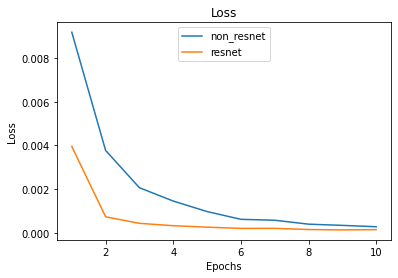

In [ ]:
models_res = {
    'non_resnet': ResNet(use_resnet=False),
    'resnet': ResNet(),
}

for (model_name, model) in models_res.items():
  print(f'Starting: {model_name}')
  train_error = train_model(model)

  plt.plot(np.linspace(1, EPOCHS, EPOCHS, dtype=int), train_error, label=model_name)
  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper center')
plt.show()

Note that, even though both networks have the same architecture, the `resnet` one, which implements the residual pass, has lower training loss given the same epoch. Note that, although they do seem to converge to the same loss, the `resnet` model becomes stable much faster. This is much more pronounced in deeper networks and in more difficult sets.

And we plot the test loss and accuracy. The test loss plotted is not averaged, unlike the training loss.

Starting: non_resnet
Accuracy: 88.6%, Avg loss per batch: 0.525841 

Avg F1 Score: 0.886174 

Avg Precision Score: 0.914409 

Avg Recall Score: 0.891760 

Starting: resnet
Accuracy: 90.5%, Avg loss per batch: 0.420637 

Avg F1 Score: 0.902877 

Avg Precision Score: 0.924482 

Avg Recall Score: 0.912272 



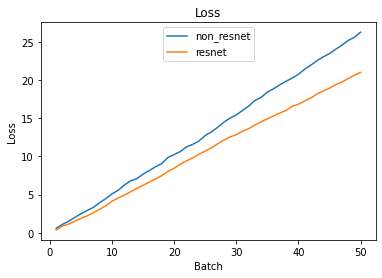

In [ ]:
for (model_name, model) in models_res.items():
  print(f'Starting: {model_name}')
  test_loss = eval(test_dataloader, model, loss_fn)
  plt.plot(np.linspace(1, len(test_loss), len(test_loss), dtype=int), test_loss, label=model_name)
  
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper center')
plt.show()

And we print some examples of what the models classified:

non_resnet


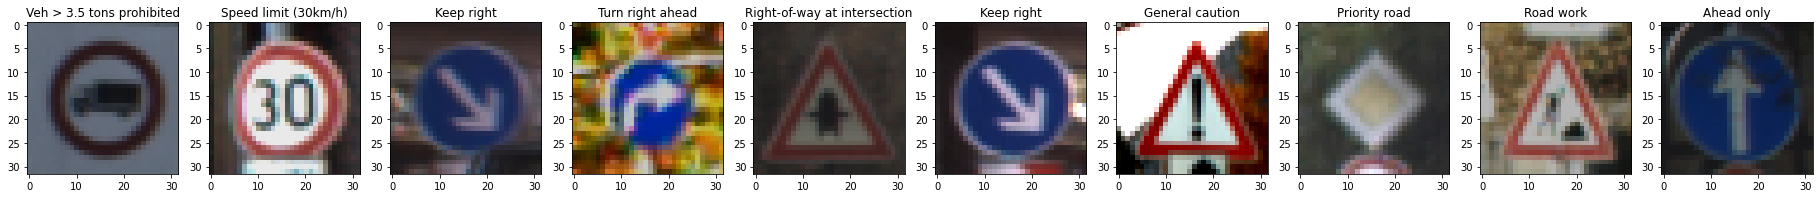



resnet


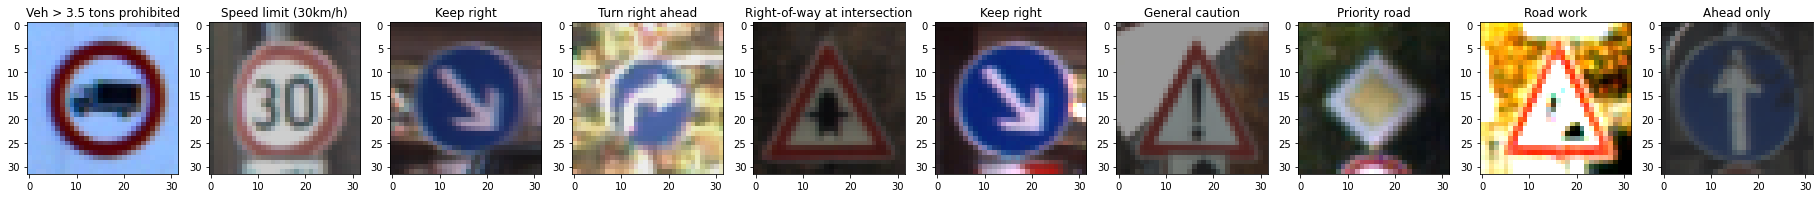

In [ ]:
for (model_name, model) in models_res.items():
  print(model_name)
  fig = plt.figure(figsize=(32, 32))
  model.eval()
  cnt = 0
  with torch.no_grad():
      for images, labels in test_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          label = []
          image = []
          for pred in predicted:
            pred = pred.cpu().item()
            label.append(classes[pred])
            cnt += 1
            if (cnt > 12):
              break
          cnt = 0
          for img in images:
              img = img.cpu()
              i = img.numpy()
              i = np.transpose(i, (1, 2, 0))
              i = i * data_std + data_mean
              image.append(i)
              cnt += 1
              if (cnt > 12):
                break
          break
  for i in range(10):
    fig.add_subplot(1, 10, i+1)
    plt.title(label[i])
    plt.imshow(image[i])
  plt.show()
  print("\n")

# Other models we did (for reference)

## LeNet

### Introduction

As a representative of the early convolutional neural network, LeNet possesses the basic units of convolutional neural network, such as convolutional layer, pooling layer and full connection layer, laying a foundation for the future development of convolutional neural network. The input is a 32x32 pixel and the entirety of LeNet consists of seven layers. In addition to input, every other layer can train parameters.

In [ ]:
import torch.nn.functional as F
# https://www.kaggle.com/code/blurredmachine/lenet-architecture-a-complete-guide/notebook
# replace softmax with relu
class LeNet(nn.Module):
  def __init__(self, num_classes=43, input_channels=3):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, 6, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = torch.flatten(x, 1) 

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

# alternate version: add batch norm

In [ ]:
# LeNet with Batch Normalization
class LeNet_BN(nn.Module):
  def __init__(self, num_classes=43, input_channels=3):
    super(LeNet_BN, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, 6, 5)
    self.conv1_bn = nn.BatchNorm2d(6)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.conv2_bn = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc1_bn = nn.BatchNorm1d(120)
    self.fc2 = nn.Linear(120, 84)
    self.fc2_bn = nn.BatchNorm1d(84)
    self.fc3 = nn.Linear(84, num_classes)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(F.relu(self.conv1_bn(x)))

    x = self.conv2(x)
    x = self.pool(F.relu(self.conv2_bn(x)))

    x = torch.flatten(x, 1) 

    x = self.fc1(x)
    x = F.relu(self.fc1_bn(x))

    x = self.fc2(x)
    x = F.relu(self.fc2_bn(x))
    
    x = self.fc3(x)

    return x

## Squeeze and Excitation Networks

In [ ]:
import torch.nn.functional as F

class SENetBlock(nn.Module):
  def __init__(self, channels, ratio=8, last_activation=nn.Sigmoid):
    super(SENetBlock, self).__init__()
    self.senet_block = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(channels, channels // ratio),
        nn.ReLU(), 
        nn.Linear(channels // ratio, channels),
        last_activation(),
    )

  def forward(self, x):
    a, b, _, _ = x.size()
    out = self.senet_block(x)

    return x * out.view(a, b, 1, 1)

Now, running each model on the test set:

## SENet (with ResNet)

In [ ]:
import functools
import torch.nn.functional as F

class SEAndResNetBlock_Temp(Block):
  def __init__(self, use_resnet, in_channels, hidden_channels, out_channels, first_stride, transition=None, last_activation=nn.Sigmoid):
    super(SEAndResNetBlock_Temp, self).__init__(in_channels, hidden_channels, out_channels, first_stride, transition)
    self.last_activation = 2
    self.use_resnet = use_resnet

    self.final_block = nn.Sequential(
        self.block,
        SENetBlock(channels=out_channels, last_activation=last_activation),
    )

  def forward(self, x):
    if self.use_resnet:
      res = x if self.transition is None else self.transition(x)
      return F.relu(res + self.final_block(x))

    return F.relu(self.final_block(x))


def SEAndResNetBlock(last_activation):
  return functools.partial(SEAndResNetBlock_Temp, last_activation=last_activation)


class SEAndResNet(nn.Module):
  def __init__(self, use_resnet=True, output_classes=43, in_channels=3, last_activation=nn.Sigmoid):
    super(SEAndResNet, self).__init__()
    self.senet = ResNet(use_resnet, output_classes, in_channels, SEAndResNetBlock(last_activation))

  def forward(self, x):
    return self.senet(x)

print(SEAndResNet())
summary(SEAndResNet().cuda(), input_size=(3, 32, 32))

## ResNet with Transfer Learning

### Introduction

We use ResNet50 deep learning model as the pre-trained model for feature extraction for Transfer Learning.

We are fine-tuning the pre-trained model on the GTSRB dataset by unfreezing the final layers of the network and retraining them on the new dataset. This allows the model to learn new, task-specific features that are relevant to the GTSRB dataset, while still leveraging the knowledge learned by the pre-trained model on the larger dataset. This can help to improve the performance of the model on the GTSRB dataset and can save time and computational resources compared to training the model from scratch.

The code modifies an existing pre-trained ResNet model by removing the final layer, flattening the output from the convolutional base, and then adding several more fully-connected layers on top.

The first added layer is a batch normalization layer, which normalizes the activations of the previous layer. This can help improve the training of the model by making the distribution of each activation more similar, which can make it easier for the optimizer to find good parameter values.

The next added layer is a linear layer with 512 units, followed by a ReLU nonlinearity, which applies the element-wise function max(0, x) to the activations. This is a common choice for the activation function in a neural network because it introduces nonlinearity, allowing the model to learn a more complex mapping from inputs to outputs.

The model then includes a dropout layer with a dropout rate of 0.45, which randomly sets a proportion of the activations of the previous layer to zero. This can help prevent overfitting by making the model less dependent on any one activation and forcing it to learn a more general representation of the data.

The model then includes another batch normalization layer, followed by a final linear layer that outputs the predicted class probabilities for each input. This final layer uses a log-softmax activation function, which is equivalent to applying the softmax function and then taking the natural logarithm of the result. This is often used in classification tasks because it allows for the prediction of probabilities, but with a more numerically stable implementation than using the raw softmax output.

In [ ]:
from torchvision import transforms, models

# Test Accuracy: 75.1%
# BATCH_SIZE = 256
# EPOCHS = 15
# LEARNING_RATE = 0.0001
BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 0.0001

# for resnet pre-trained
train_dataloader = DataLoader(trainset_rpt, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(valset_rpt, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(testset_rpt, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# load pre-trained model
model = torchvision.models.resnet18(pretrained=True).to(device)

# freeze layers
for param in model.parameters():
    param.requires_grad = False

num_classes=43
num_ftrs = model.fc.in_features

model = nn.Sequential(
          *list(model.children())[:-1],
          nn.Flatten(),
          nn.BatchNorm1d(num_ftrs),
          nn.Linear(num_ftrs, 512),
          nn.ReLU(inplace=True),
          nn.Dropout(0.45),
          nn.BatchNorm1d(512),
          nn.Linear(512, num_classes),
          nn.LogSoftmax(dim=1)
        )
list(model.children())

One reason why the test set saw lower accuracy is because of the split of the data. 
In general, having a large amount of data in the test set relative to the size of the training set can make it more difficult for a model to achieve high accuracy on the test set. This is because a model is typically trained on the training set in order to learn the patterns in the data that are relevant for making accurate predictions. In most cases, the split of data should be 80% training, 10% validation, and 10% testing. However, in this case, the way the datasets were already pre-processed, left a lot more data in the test set than would be optimal to achieve the best model. In the case of a pre-trained model that relies on the validation set for fine-tuning, the ratio becomes important to cover as many test cases as possible. However, the validation to testing ratio was almost 1:2, making it difficult to generalize to the testing cases, thus lowering its accuracy in comparison with validation set.

Another reason transfer learning's accuracy rate is lower is likely due to the fact that it is pretrained on `ImageNet` data, whose classifications do not reflect the classification depth we need for traffic signals. Because the set of data it is trained on is so differently recognized and classified in comparison with GTSRB, it is better to train it from scratch.

In [ ]:
trained = train_model(model)
eval(test_dataloader, model, loss_fn)

## Inception Net


### Introduction

In an image classification task, the size of the salient feature can considerably vary within the image frame. Hence, deciding on a fixed kernel size is rather difficult. Larger kernels are preferred for more global features that are distributed over a large area of the image, on the other hand, smaller kernels provide good results in detecting area-specific features that are distributed across the image frame. For effective recognition of traffic signals while driving, it makes sense to implement a neural network capable of these variations. Instead of simply going deeper in terms of the number of layers, it goes wider with kernels of different sizes. Multiple kernels of different sizes are implemented within the same layer.

We will be implementing a variation of GoogLeNet, one of the simplest forms of Inception Net.

In [ ]:
# for inception net pre-trained
train_dataloader = DataLoader(trainset_inc, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(valset_inc, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(testset_inc, batch_size=BATCH_SIZE, shuffle=False)
# Current Test Accuracy: 

model = models.inception_v3(pretrained=True).to(device)

for parameter in model.parameters():
    parameter.requires_grad = False

num_classes=43

# Handle the auxilary net
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

# Handle the primary net
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(          
          nn.Flatten(),
          nn.BatchNorm1d(num_ftrs),
          nn.Linear(num_ftrs, 512),
          nn.ReLU(inplace=True),
          nn.Dropout(0.45),
          nn.BatchNorm1d(512),
          nn.Linear(512, num_classes),
          nn.LogSoftmax(dim=1)
        )


Because Inception Net outputs 2 tensors and only one tensor is passed into the loss function as `y_pred`, we need to make sure that the first argument you pass to the cross_entropy_loss function is a Tensor that has the right shape and format. The two output tensors Inception Net gives are `Logits` and `AuxLogits`. The key difference between logits and auxiliary logits is that logits are used to make the final predictions for the model, while auxlogits are used to provide additional information that can help improve the accuracy of the model. For example, in the Inception network, the auxlogits are the outputs of intermediate layers of the network that are fed into the final prediction layer, along with the logits, to make the final predictions. This allows the model to make more accurate predictions by incorporating information from multiple layers of the network. the tensor we want is the `logits` tensor. So we modify our training function.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)

  model.train()

  running_loss = 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred.logits, y) # change

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss = loss.item()

    running_loss += loss

    if batch % 100 == 0:
      current = batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  return running_loss / size

In [ ]:
trained = train_model(model)
eval(test_dataloader, model, loss_fn)

In [ ]:
eval(test_dataloader, model, loss_fn)

## Inception Net GoogLeNetV3

### Introduction

GoogLeNet V3 is a convolutional neural network (CNN) that uses a combination of convolutional layers and inception modules to extract features from input data. The model takes in a tensor with a specified number of channels as input and processes it through a series of convolutional and pooling layers to reduce its size and increase the number of channels. This is followed by a series of inception modules that learn to combine features from different spatial sizes and aspect ratios. The model then uses another series of convolutional and pooling layers to further reduce the size of the feature map and increase the number of channels. Finally, the model uses a fully-connected layer to make predictions based on the extracted features

In [ ]:
# Inception Net
class GoogLeNetV3(nn.Module):
    def __init__(self, channels_in):
        super(GoogLeNetV3, self).__init__()
        self.in_block = nn.Sequential(
            Conv2d_BN(channels_in, 32, 3, stride=2, padding=1),  # size /= 2
            Conv2d_BN(32, 32, 3, stride=1, padding=1),
            Conv2d_BN(32, 64, 3, stride=1, padding=1),
            nn.MaxPool2d(3, stride=2, padding=1),  # size /= 2
            Conv2d_BN(64, 80, 1, stride=1, padding=0),
            Conv2d_BN(80, 192, 3, stride=1, padding=1),
            nn.MaxPool2d(3, stride=2, padding=1)  # size /= 2
        )  # 192 channels
        self.mix_block = nn.Sequential(
            InceptionA(192, 32),
            InceptionA(256, 64),
            InceptionA(288, 64),
            InceptionB(288),  # size /= 2
            InceptionC(768, 128),
            InceptionC(768, 160),
            InceptionC(768, 160),
            InceptionC(768, 192),
            InceptionD(768),  # size /= 2
            InceptionE(1280),
            InceptionE(2048)
        )  # 2048 channels
        self.out_block = nn.Sequential(
            Conv2d_BN(2048, 1024, 1, stride=1, padding=0),
            nn.AdaptiveAvgPool2d(1)
        )  # 1024 channels
        self.full_connect = nn.Linear(1024, 1)
        
    def forward(self, x):
        x = self.in_block(x)
        x = self.mix_block(x)
        x = self.out_block(x)
        x = torch.flatten(x, 1)
        return self.full_connect(x)

class Conv2d_BN(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size, padding, stride=1, acti=nn.LeakyReLU(0.2, inplace=True)):
        super(Conv2d_BN, self).__init__()
        self.conv2d_bn = nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(channels_out),
            acti
        )

    def forward(self, x):
        return self.conv2d_bn(x)

class InceptionA(nn.Module):
    def __init__(self, channels_in, pool_channels):
        super(InceptionA, self).__init__()
        self.branch1x1 = Conv2d_BN(channels_in, 64, 1, stride=1, padding=0)  # 64 channels
        self.branch5x5 = nn.Sequential(
            Conv2d_BN(channels_in, 48, 1, stride=1, padding=0),
            Conv2d_BN(48, 64, 5, stride=1, padding=2)
        )  # 64 channels
        self.branch3x3dbl = nn.Sequential(
            Conv2d_BN(channels_in, 64, 1, stride=1, padding=0),
            Conv2d_BN(64, 96, 3, stride=1, padding=1),
            Conv2d_BN(96, 96, 3, stride=1, padding=1)
        )  # 96 channels
        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1),
            Conv2d_BN(channels_in, pool_channels, 1, stride=1, padding=0)
        )  # pool_channels

    def forward(self, x):
        outputs = [self.branch1x1(x), self.branch5x5(x), self.branch3x3dbl(x), self.branch_pool(x)]
        # 64 + 64 + 96 + pool_channels
        return torch.cat(outputs, 1)

class InceptionB(nn.Module):
    def __init__(self, channels_in):
        super(InceptionB, self).__init__()
        self.branch3x3 = Conv2d_BN(channels_in, 384, 3, stride=2, padding=1)  # 384 channels
        self.branch3x3dbl = nn.Sequential(
            Conv2d_BN(channels_in, 64, 1, padding=0),
            Conv2d_BN(64, 96, 3, padding=1),
            Conv2d_BN(96, 96, 3, stride=2, padding=1)
        )  # 96 channels
        self.branch_pool = nn.MaxPool2d(3, stride=2, padding=1)  # channels_in

    def forward(self, x):
        outputs = [self.branch3x3(x), self.branch3x3dbl(x), self.branch_pool(x)]
        # 384 + 96 + channels_in
        return torch.cat(outputs, 1)

class InceptionC(nn.Module):
    def __init__(self, channels_in, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = Conv2d_BN(channels_in, 192, 1, stride=1, padding=0)  # 192 channels
        self.branch7x7 = nn.Sequential(
            Conv2d_BN(channels_in, channels_7x7, 1, stride=1, padding=0),
            Conv2d_BN(channels_7x7, channels_7x7, (1, 7), stride=1, padding=(0, 3)),
            Conv2d_BN(channels_7x7, 192, (7, 1), stride=1, padding=(3, 0))
        )  # 192 channels
        self.branch7x7dbl = nn.Sequential(
            Conv2d_BN(channels_in, channels_7x7, 1, stride=1, padding=0),
            Conv2d_BN(channels_7x7, channels_7x7, (7, 1), stride=1, padding=(3, 0)),
            Conv2d_BN(channels_7x7, channels_7x7, (1, 7), stride=1, padding=(0, 3)),
            Conv2d_BN(channels_7x7, channels_7x7, (7, 1), stride=1, padding=(3, 0)),
            Conv2d_BN(channels_7x7, 192, (1, 7), stride=1, padding=(0, 3))
        )  # 192 channels
        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1),
            Conv2d_BN(channels_in, 192, 1, stride=1, padding=0)
        )  # 192 channels
    
    def forward(self, x):
        outputs = [self.branch1x1(x), self.branch7x7(x), self.branch7x7dbl(x), self.branch_pool(x)]
        # 192 + 192 + 192 + 192 = 768 channels
        return torch.cat(outputs, 1)

class InceptionD(nn.Module):
    def __init__(self, channels_in):
        super(InceptionD, self).__init__()
        self.branch3x3 = nn.Sequential(
            Conv2d_BN(channels_in, 192, 1, stride=1, padding=0),
            Conv2d_BN(192, 320, 3, stride=2, padding=1)
        )  # 320 channels
        self.branch7x7x3 = nn.Sequential(
            Conv2d_BN(channels_in, 192, 1, stride=1, padding=0),
            Conv2d_BN(192, 192, (1, 7), stride=1, padding=(0, 3)),
            Conv2d_BN(192, 192, (7, 1), stride=1, padding=(3, 0)),
            Conv2d_BN(192, 192, 3, stride=2, padding=1)
        )  # 192 chnnels
        self.branch_pool = nn.MaxPool2d(3, stride=2, padding=1)  # channels_in

    def forward(self, x):
        outputs = [self.branch3x3(x), self.branch7x7x3(x), self.branch_pool(x)]
        # 320 + 192 + channels_in
        return torch.cat(outputs, 1)

class InceptionE(nn.Module):
    def __init__(self, channels_in):
        super(InceptionE, self).__init__()
        self.branch1x1 = Conv2d_BN(channels_in, 320, 1, stride=1, padding=0)  # 320 channels

        self.branch3x3_1 = Conv2d_BN(channels_in, 384, 1, stride=1, padding=0)
        self.branch3x3_2a = Conv2d_BN(384, 384, (1, 3), stride=1, padding=(0, 1))
        self.branch3x3_2b = Conv2d_BN(384, 384, (3, 1), stride=1, padding=(1, 0))
        # 768 channels

        self.branch3x3dbl_1 = nn.Sequential(
            Conv2d_BN(channels_in, 448, 1, stride=1, padding=0),
            Conv2d_BN(448, 384, 3, stride=1, padding=1)
        )
        self.branch3x3dbl_2a = Conv2d_BN(384, 384, (1, 3), stride=1, padding=(0, 1))
        self.branch3x3dbl_2b = Conv2d_BN(384, 384, (3, 1), stride=1, padding=(1, 0))
        # 768 channels
        
        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1),
            Conv2d_BN(channels_in, 192, 1, stride=1, padding=0)
        )  # 192 channels
    
    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = torch.cat([self.branch3x3_2a(branch3x3), self.branch3x3_2b(branch3x3)], 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = torch.cat([self.branch3x3dbl_2a(branch3x3dbl), self.branch3x3dbl_2b(branch3x3dbl)], 1)

        branch_pool = self.branch_pool(x)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        # 320 + 768 + 768 + 192 = 2048 channels
        return torch.cat(outputs, 1)